# MultiNest sampling

This example demonstrates how to use MultiNest sampling [1] to sample from the posterior distribution for a logistic model fitted to model-simulated data.

[1] "MultiNest: an efficient and robust Bayesian inference tool for cosmology and particle physics."
Feroz, F., M. P. Hobson, and M. Bridges. Monthly Notices of the Royal Astronomical Society 398.4 (2009): 1601-1614.

MultiNest works similarly to [ellipsoidal nested sampling](nested-ellipsoidal-sampling.ipynb) by proposing points using the prior but constraining the proposals such that they lie within ellipsoids of known high density. A key difference is that MultiNest uses (potentially) many ellipsoids to generate proposals, unlike ellipsoidal nested sampling, which uses only a single ellipsoid.

## Ellipsoids and ellipsoid trees

We illustrate this using the `Ellipsoid()` and `EllipsoidTree()` classes in PINTS. Whilst users do not need these to perform inference, we use them here to visualise the ellipses generated by fitting to two-dimensional data.

We first generate some sample data which we'll fit bounding ellipses to.

In [1]:
import os
os.chdir("../..")
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

We'll first draw some data from the [AnnulusLogPDF](../toy/http://localhost:8888/notebooks/pints/examples/toy/distribution-annulus.ipynb) example. Note that the ellipsoid tree methods work only within the unit cube, so we transform all points to lie within the [0,1]^2 range.

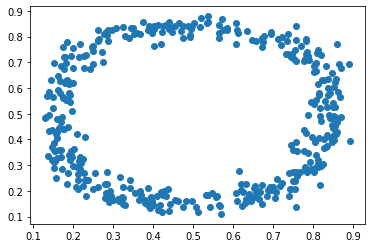

In [2]:
n = 400
log_pdf = pints.toy.AnnulusLogPDF()
draws = log_pdf.sample(400)
gaussian = pints.MultivariateGaussianLogPrior([0, 0], [[100, 0], [0, 100]])
draws = [gaussian.convert_to_unit_cube(x) for x in draws]
draws = np.vstack(draws)

plt.scatter(draws[:, 0], draws[:, 1])
plt.show()

Now we'll fit an ellipsoid tree to the data, which provides an ellipsoidal decomposition of the domain covered by the sample draws.

In [3]:
from pints._nested.__init__ import Ellipsoid
from pints._nested._multinest import EllipsoidTree

iteration = 600 # this number can be ignored for understanding this method for now
ellipsoid_tree = EllipsoidTree(draws, iteration)

Now plotting the ellipsoids (here, because the domain is 2D, these are actually ellipses) resultant from the spatial decomposition.

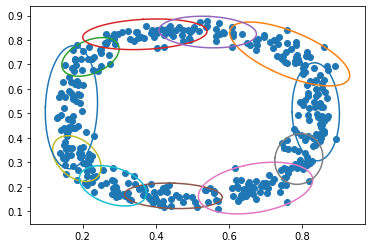

In [4]:
def plot_2d_ellipsoid(ellipsoid):
    A = ellipsoid.weight_matrix()
    c = ellipsoid.centroid()

    U, D, V = np.linalg.svd(A)

    # major and minor axes
    a = 1 / np.sqrt(D[0])
    b = 1 / np.sqrt(D[1])

    # generate x and y
    theta = np.linspace(0, 2 * np.pi, 1000)
    state_1 = a * np.cos(theta)
    state_2 = b * np.sin(theta)
    state = np.vstack((state_1, state_2))
    z = np.matmul(V, state)
    x = z[0, :] + c[0]
    y = z[1, :] + c[1]

    plt.plot(x, y)

def plot_2d_ellipsoid_tree_leaves(ellipsoid_tree):
    ellipsoids = ellipsoid_tree.leaf_ellipsoids()
    for ellipsoid in ellipsoids:
        plot_2d_ellipsoid(ellipsoid)
        
plot_2d_ellipsoid_tree_leaves(ellipsoid_tree)
plt.scatter(draws[:, 0], draws[:, 1])
plt.show()

This ellipsoidal decomposition in stochastic: each replicate can yield a different decomposition.

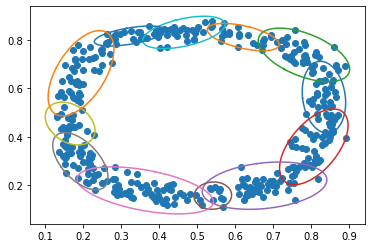

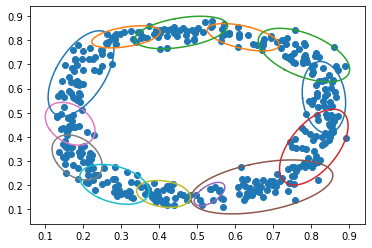

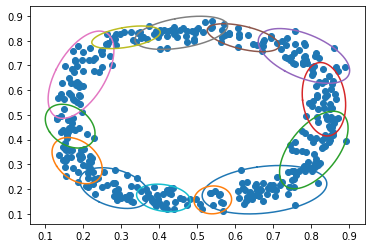

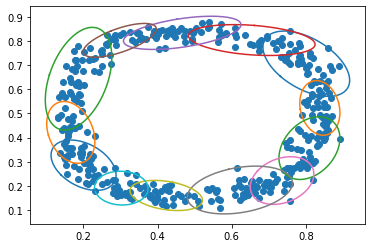

In [5]:
nreps = 4
for i in range(nreps):
    ellipsoid_tree = EllipsoidTree(draws, iteration)

    plot_2d_ellipsoid_tree_leaves(ellipsoid_tree)
    plt.scatter(draws[:, 0], draws[:, 1])
    plt.show()

In MultiNest, this ellipsoidal decomposition would be used to generate proposals which have an improved change of being accepted as part of a nested sampling algorithm. In PINTS' implementation of the ellipsoidal tree, we can sample uniformly within these ellipsoid set. This accounts for the overlap in the ellipses to ensure uniform sampling within the set.

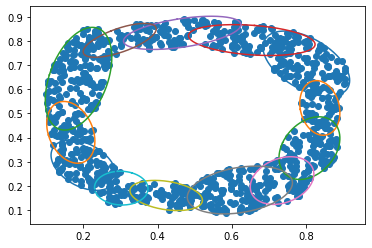

In [6]:
test_draws = ellipsoid_tree.sample_leaf_ellipsoids(1000)
test_draws = np.vstack(test_draws)

plot_2d_ellipsoid_tree_leaves(ellipsoid_tree)
plt.scatter(test_draws[:, 0], test_draws[:, 1])
plt.show()

# Inference for the egg box problem

We now illustrate inference for the [egg box problem](distribution-simple-egg-box.ipynb): this problem is highly multimodal and causes issues for MCMC methods. Here, for ease of visualisation and to further separate the modes, we transform the dimensions.

In [58]:
class ExampleToy(pints.LogPDF):
    def __init__(self, sigma, r):
        self._sigma = sigma
        self._r = r
        self._log_toy = pints.toy.SimpleEggBoxLogPDF(self._sigma, self._r)

    def __call__(self, x):
        x1 = np.copy(x)
        x1[0] = -15 + 30 * x[0]
        x1[1] = -15 + 30 * x[1]
        return self._log_toy(x1)

    def n_parameters(self):
        return 2

log_pdf = ExampleToy(2, 4)
log_prior = pints.UniformLogPrior(
    [0.0, 0.0],
    [1.0, 1.0])

We set up the MultiNest sampler.

In [62]:
controller = pints.NestedController(log_pdf, log_prior, method=pints.MultinestSampler)

# Set number of iterations
controller.set_iterations(2000)

# Set the number of posterior samples to generate
controller.set_n_posterior_samples(500)

# Set threshold for updating ellipsoids as sampling runs
controller.sampler().set_f_s_threshold(2)

We run the sampler: note that the ellipsoid tree may be updated as the sampler runs, resulting in differing numbers of ellipsoids in the decomposition over time.

In [63]:
samples = controller.run()
print('Done!')

Running MultiNest sampler
Number of active points: 400
Total number of iterations: 2000
Total number of posterior samples: 500
Iter. Eval. Time m:s Delta_log(z) Acceptance rate Ellipsoid count
0     1       0:00.0 -inf          1               0             
0     2       0:00.0 -inf          1               0             
0     21      0:00.0 -inf          1               0             
0     41      0:00.0 -inf          1               0             
0     61      0:00.0 -inf          1               0             
0     81      0:00.0 -inf          1               0             
0     101     0:00.0 -inf          1               0             
0     121     0:00.0 -inf          1               0             
0     141     0:00.0 -inf          1               0             
0     161     0:00.1 -inf          1               0             
0     181     0:00.1 -inf          1               0             
0     201     0:00.1 -inf          1               0             
0     221     0

We can plot the samples over the target density, and the draws appear to be a reasonable fit to the underlying density.

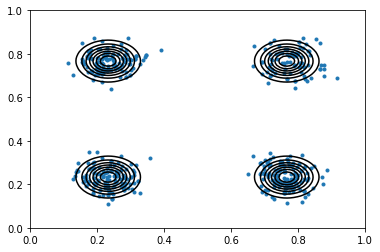

In [65]:
# Contour plot of pdf
levels = np.linspace(-100, 0, 20)
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
Z = [[np.exp(log_pdf([i, j])) for i in x] for j in y]

plt.figure()
plt.contour(X, Y, Z, colors='k')
plt.scatter(samples[:, 0], samples[:, 1], marker='.')
plt.show()

Throughout sampling, the number of ellipsoids in the decomposition can vary. We can, however, visualise the final decomposition used in sampling.

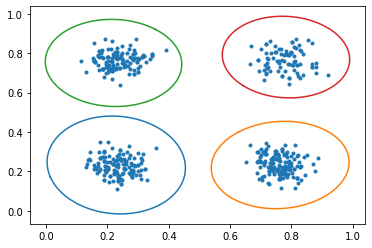

In [66]:
et = controller.sampler().ellipsoid_tree()
plot_2d_ellipsoid_tree_leaves(et)
draws = [log_prior.convert_to_unit_cube(x) for x in samples]
draws = np.vstack(draws)

plt.scatter(draws[:, 0], draws[:, 1], marker='.')
plt.show()

We can print the effective sample size...

In [67]:
print('effective sample size = ' + str(controller.effective_sample_size()))

effective sample size = 1330.9562452137627


...and print our estimate of the marginal likelihood.

In [68]:
print('marginal log-likelihood = ' + str(controller.marginal_log_likelihood())
      + ' ± ' + str(controller.marginal_log_likelihood_standard_deviation()))

marginal log-likelihood = -5.291018125179454 ± 0.05763048460881286


## ODE inference for logistic model

In [41]:
model = toy.LogisticModel()

# Create some toy data
times = np.linspace(0, 1000, 50)
real_parameters = np.array([0.015, 500])
org_values = model.simulate(real_parameters, times)

# Add noise
np.random.seed(1)
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

# Create a uniform prior over the parameters
log_prior = pints.UniformLogPrior(
    [0.01, 400],
    [0.02, 600]
)

In [42]:
# Run sampling on the noisy data
x0 = [[5, 5, 0.5, 0.5, 0.5]]*3
controller = pints.NestedController(log_likelihood, log_prior, method=pints.MultinestSampler)

# Set number of iterations
controller.set_iterations(3000)

# Set the number of posterior samples to generate
controller.set_n_posterior_samples(1000)

# Set threshold for updating ellipsoids as sampling runs
controller.sampler().set_f_s_threshold(1.1)

samples = controller.run()
print('Done!')

Running MultiNest sampler
Number of active points: 400
Total number of iterations: 3000
Total number of posterior samples: 1000
Iter. Eval. Time m:s Delta_log(z) Acceptance rate Ellipsoid count
0     1       0:00.0 -inf          1               0             
0     2       0:00.0 -inf          1               0             
0     21      0:00.0 -inf          1               0             
0     41      0:00.0 -inf          1               0             
0     61      0:00.0 -inf          1               0             
0     81      0:00.0 -inf          1               0             
0     101     0:00.0 -inf          1               0             
0     121     0:00.0 -inf          1               0             
0     141     0:00.0 -inf          1               0             
0     161     0:00.0 -inf          1               0             
0     181     0:00.0 -inf          1               0             
0     201     0:00.0 -inf          1               0             
0     221     

2020  16463   0:10.2 -14.11787944  0.12575484      1             
2040  17194   0:10.6 -13.49516116  0.121471954     1             
2060  18344   0:11.1 -12.92788209  0.114801605     1             
2080  19482   0:11.7 -12.38398107  0.109003249     1             
2100  20452   0:12.1 -11.83574711  0.104727708     1             
2120  21952   0:12.8 -11.33692981  0.0983667409    1             
2140  22757   0:13.2 -10.84245656  0.0957194615    1             
2160  23841   0:13.7 -10.3650647   0.0921462395    1             
2180  24742   0:14.2 -9.912566727  0.089557144     1             
2200  26536   0:15.0 -9.484245748  0.0841750842    1             
2220  28453   0:15.9 -9.014113709  0.0791359213    1             
2240  30071   0:16.7 -8.513683926  0.0754945907    1             
2260  31384   0:17.4 -8.058370958  0.0729408727    1             
2280  32917   0:18.1 -7.641058467  0.0701171695    1             
2300  34313   0:18.8 -7.301359703  0.06782059977   1             
2320  3646

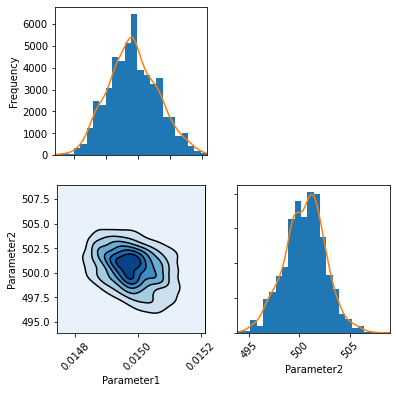

In [43]:
import pints.plot

pints.plot.pairwise(samples, kde=True)
plt.show()